In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'

### Load CSV

In [2]:
import pandas as pd

train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
sub_df = pd.read_csv("./sample_submission.csv")

In [3]:
train_df.head(1)

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,./train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head(1)

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg


In [5]:
sub_df.head(1)

,id,A,B,C,D,E,F,G,H,I,J
0,TEST_00000,0,0,0,0,0,0,0,0,0,0


### mini EDA

##### - 라벨별 갯수

In [6]:
import numpy as np

np.sum(train_df.values[:, 2:], axis=0)

array([14531, 14547, 14491, 14481, 14600, 14626, 14499, 14300, 14402,
       14412], dtype=object)

##### - 이미지 사이즈

In [7]:
from tqdm import tqdm
import numpy as np
import cv2

shapes = list(tqdm(map(lambda x:cv2.imread(x).shape, train_df["img_path"])))
print(np.unique(shapes, axis=0, return_counts=True))
shapes = list(tqdm(map(lambda x:cv2.imread(x).shape, test_df["img_path"])))
print(np.unique(shapes, axis=0, return_counts=True))

1929it [00:04, 405.91it/s]


KeyboardInterrupt: 

##### - 이미지 한번 보기

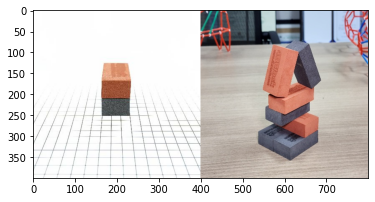

In [7]:
import matplotlib.pyplot as plt
import cv2

temp1 = cv2.imread(train_df["img_path"][0])
temp2 = cv2.imread(test_df["img_path"][0])
temp = cv2.hconcat([temp1, temp2])

plt.imshow(temp[:,:,::-1])

### Remove Grid in train_img

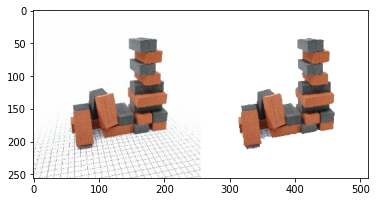

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def remove_grid(img):
    # 배경 부분 얻기
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_bg = cv2.inRange(img_hsv, (0, 0, 200), (360, 10, 255))
    
    # mopology로 그리드 제거, 마스크 얻기
    kernel = np.ones((3,3))
    mask = 255 - cv2.dilate(img_bg, kernel)
    
    # 마스크 부분만 원본에서 가져온후 합성
    white = np.zeros_like(img) + 255
    white[mask != 0] = img[mask != 0]
    return white, mask

img = cv2.imread(train_df["img_path"][20000])
img = cv2.resize(img, dsize=(256,256))
new_img, mask = remove_grid(img)
new_img = cv2.hconcat([img, new_img])

plt.imshow(new_img[:,:,::-1])

### 이미지 합성하기

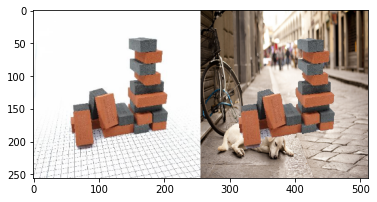

In [9]:
import cv2

def get_synthetic_image(src_img, dst_img, mask):
    dst_img = cv2.resize(dst_img, dsize=src_img.shape[:2])
    dst_img[mask!=0] = src_img[mask!=0]
    return dst_img

dst_img = cv2.imread("../../_dataset/train2017/000000000074.jpg")
new_img = get_synthetic_image(img, dst_img, mask)
new_img = cv2.hconcat([img, new_img])

plt.imshow(new_img[:,:,::-1])

### 전처리 이미지 저장

In [10]:
import os

if not os.path.isdir("./new_train"): os.mkdir("./new_train")
if not os.path.isdir("./new_test"): os.mkdir("./new_test")

In [11]:
from tqdm import tqdm

# train
for img_path in tqdm(train_df["img_path"]):
    name = img_path.split('/')[-1]
    save_path = os.path.join("./new_train", name)
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=(256,256))
    img = remove_grid(img)[0]
    cv2.imwrite(save_path, img)
    
# test
for img_path in tqdm(test_df["img_path"]):
    name = img_path.split('/')[-1]
    save_path = os.path.join("./new_test", name)
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=(256,256))
    cv2.imwrite(save_path, img)

  7%|▋         | 2214/32994 [00:10<02:25, 211.64it/s]


KeyboardInterrupt: 

In [11]:
from glob import glob

train_img_path = sorted(glob("./new_train/*.jpg"))
test_img_path = sorted(glob("./new_test/*.jpg"))
print("train len : ", len(train_img_path))
print("test len : ", len(test_img_path))

train len :  32994
test len :  1460


### test masking with tf

In [12]:
import tensorflow as tf

img = tf.image.decode_jpeg(tf.io.read_file(train_img_path[20000]))
# img = tf.image.decode_jpeg(tf.io.read_file('./rainbow.jpg'))
img = tf.image.convert_image_dtype(img, tf.float32)
img_hsv = tf.image.rgb_to_hsv(img)

In [13]:
cond1 = tf.constant([0, 0, 0.8], dtype=tf.float32, shape=(1,1,3))
cond2 = tf.constant([1, 0.09, 1], dtype=tf.float32, shape=(1,1,3))

temp = tf.concat([cond1 <= img_hsv, img_hsv <= cond2], axis=-1)
mask = tf.reduce_all(temp, axis=-1)

In [14]:
aa = tf.where(mask[...,None], 0, img)

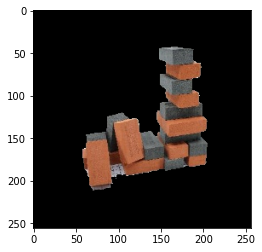

In [15]:
import matplotlib.pyplot as plt

plt.imshow(aa)

### Multi GPU strategy

In [16]:
strategy = tf.distribute.MirroredStrategy(devices=["/GPU:0","/GPU:1","/GPU:2",])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Number of devices: 3


### Make Dataset with tf

In [17]:
import tensorflow as tf
from glob import glob
import cv2
import numpy as np

BG_PATHS = glob("../../_dataset/train2017/*.jpg")
IMG_SIZE = (256, 256)

        
def load_img(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, IMG_SIZE) / 255
    # img = tf.image.decode_jpeg(tf.io.read_file(path))
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # img = tf.image.resize(img, IMG_SIZE)
    return img

def synthetic(img, bg):    
    # get mask
    img_hsv = tf.image.rgb_to_hsv(img)
    cond1 = tf.constant([0, 0, 0.8], dtype=tf.float32, shape=(1,1,3))
    cond2 = tf.constant([1, 0.09, 1], dtype=tf.float32, shape=(1,1,3))
    temp = tf.concat([cond1 <= img_hsv, img_hsv <= cond2], axis=-1)
    mask = ~tf.reduce_all(temp, axis=-1)[...,None]
    
    # 이미지 합성
    img_x = tf.where(mask, img, bg)
    mask = tf.cast(mask, tf.float32)
    
    # augmentation
    if tf.random.uniform(()) > 0.5:
        img_x = tf.image.flip_left_right(img_x)
        mask = tf.image.flip_left_right(mask)
    img_x = tf.image.random_jpeg_quality(img_x, 90, 100)
    img_x = tf.image.random_brightness(img_x, 0.05)
    img_x = tf.image.random_contrast(img_x, 0.95, 1.05)
    img_x = tf.clip_by_value(img_x, 0, 1)
    
    return img_x, mask

### Load Images

In [18]:
from glob import glob
import multiprocessing
import parmap

BG_PATHS = glob("../../_dataset/train2017/*.jpg")[:30000]

num_cores = multiprocessing.cpu_count()

bg_imgs = parmap.map(load_img, BG_PATHS, pm_pbar=True, pm_processes=num_cores)
bg_len = len(bg_imgs)
print(bg_len)

/home/ubuntu/anaconda3/envs/tt38_cu113/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
30048it [03:01, 165.98it/s]                           


30000


In [19]:
train_imgs = parmap.map(load_img, train_img_path, pm_pbar=True, pm_processes=num_cores)
test_imgs = parmap.map(load_img, test_img_path, pm_pbar=True, pm_processes=num_cores)
print(len(train_imgs))
print(len(test_imgs))

33024it [03:21, 163.74it/s]                           
1472it [00:06, 232.56it/s]                          


32994
1460


In [20]:
def pair_generator(idxs):    
    for i in idxs:
        img = train_imgs[i]
        ind = np.random.randint(len(bg_imgs))
        bg = bg_imgs[ind]
        img_x, mask = synthetic(img, bg)
        yield img_x, mask

In [49]:
train_idxs = np.arange(len(train_imgs))
np.random.shuffle(train_idxs)

train_ds = tf.data.Dataset.from_generator(pair_generator, output_types=(tf.float32, tf.float32), 
                                    output_shapes=([256,256,3], [256,256,1]), args=(train_idxs,))
train_ds = train_ds.batch(GLOBAL_BATCH_SIZE)
train_ds = strategy.experimental_distribute_dataset(train_ds)

In [50]:
import matplotlib.pyplot as plt

aa = next(iter(train_ds))

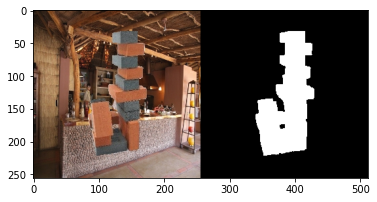

In [52]:
import tensorflow as tf
import cv2

img1 = aa[0].values[0][0].numpy()
img2 = aa[1].values[0][0]
img2 = tf.tile(img2, [1,1,3]).numpy()
temp = cv2.hconcat([img1, img2])

plt.imshow(temp)

### Define Generator, Discriminator

In [56]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())

    return result

In [57]:
# OUTPUT_CH = 1

# def Generator():
#     inputs = tf.keras.layers.Input(shape=[256,256,3])

#     down_stack = [
#         downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
#         downsample(128, 4), # (bs, 64, 64, 128)
#         downsample(256, 4), # (bs, 32, 32, 256)
#         downsample(512, 4), # (bs, 16, 16, 512)
#         downsample(512, 4), # (bs, 8, 8, 512)
#         downsample(512, 4), # (bs, 4, 4, 512)
#         downsample(512, 4), # (bs, 2, 2, 512)
#         downsample(512, 4), # (bs, 1, 1, 512)
#     ]

#     up_stack = [
#         upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
#         upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
#         upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
#         upsample(512, 4), # (bs, 16, 16, 1024)
#         upsample(256, 4), # (bs, 32, 32, 512)
#         upsample(128, 4), # (bs, 64, 64, 256)
#         upsample(64, 4), # (bs, 128, 128, 128)
#     ]

#     initializer = tf.random_normal_initializer(0., 0.02)
#     last = tf.keras.layers.Conv2DTranspose(OUTPUT_CH, 4, strides=2, padding='same',
#                                            kernel_initializer=initializer, activation='sigmoid') # (bs, 256, 256, 3)

#     x = inputs

#     # Downsampling through the model
#     skips = []
#     for down in down_stack:
#         x = down(x)
#         skips.append(x)

#     skips = reversed(skips[:-1])

#     # Upsampling and establishing the skip connections
#     for up, skip in zip(up_stack, skips):
#         x = up(x)
#         x = tf.keras.layers.Concatenate()([x, skip])

#     x = last(x)

#     return tf.keras.Model(inputs=inputs, outputs=x)

In [58]:
OUTPUT_CH = 1

def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(32, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(64, 4), # (bs, 64, 64, 128)
        downsample(128, 4), # (bs, 32, 32, 256)
        downsample(256, 4), # (bs, 16, 16, 512)
        downsample(256, 4), # (bs, 8, 8, 512)
        downsample(256, 4), # (bs, 4, 4, 512)
        downsample(256, 4), # (bs, 2, 2, 512)
        downsample(256, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(256, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(256, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(256, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(256, 4), # (bs, 16, 16, 1024)
        upsample(128, 4), # (bs, 32, 32, 512)
        upsample(64, 4), # (bs, 64, 64, 256)
        upsample(32, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CH, 4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [59]:
# def Discriminator():
#     initializer = tf.random_normal_initializer(0., 0.02)

#     inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
#     tar = tf.keras.layers.Input(shape=[256, 256, OUTPUT_CH], name='target_image')

#     x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

#     x = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
#     x = downsample(128, 4)(x) # (bs, 64, 64, 128)
#     x = downsample(256, 4)(x) # (bs, 32, 32, 256)

#     x = tf.keras.layers.ZeroPadding2D()(x) # (bs, 34, 34, 256)
#     x = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, 
#                                use_bias=False)(x) # (bs, 31, 31, 512)

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
    
#     x = tf.keras.layers.ZeroPadding2D()(x) # (bs, 33, 33, 512)
#     x = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (bs, 30, 30, 1)

#     return tf.keras.Model(inputs=[inp, tar], outputs=x)

In [60]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, OUTPUT_CH], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    x = downsample(32, 4, False)(x) # (bs, 128, 128, 32)
    x = downsample(64, 4)(x) # (bs, 64, 64, 64)
    x = downsample(128, 4)(x) # (bs, 32, 32, 128)
    x = downsample(256, 4)(x) # (bs, 16, 16, 256)
    x = downsample(256, 4)(x) # (bs, 8, 8, 256)
    x = downsample(512, 4)(x) # (bs, 4, 4, 512)
    x = downsample(512, 4)(x) # (bs, 2, 2, 512)
    x = downsample(512, 4)(x) # (bs, 1, 1, 512)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=[inp, tar], outputs=x)

### Define Loss

In [96]:
with strategy.scope():
    LAMBDA = 10
    # loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    def generator_loss(disc_generated_output, gen_output, target):
        gen_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

        # MAE
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

        total_gen_loss = gen_loss + (LAMBDA * l1_loss)
        return total_gen_loss, gen_loss, l1_loss

    def discriminator_loss(disc_real_output, disc_generated_output):
        real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
        generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

        total_disc_loss = real_loss + generated_loss
        return total_disc_loss

### Training

In [97]:
with strategy.scope():
    generator = Generator()
    discriminator = Discriminator()
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

In [98]:
def generate_images(model, test_img):
    prediction = model(test_img[None], training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_img, prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

In [35]:
# generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [107]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)
        
@tf.function
def mirrored_train_step(input_image, target, epoch):
    per_replica_losses = strategy.run(train_step, args=(input_image, target, epoch))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=1)

In [108]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [109]:
from IPython import display
import cv2
import matplotlib.pyplot as plt
import time

def fit(train_ds, epochs):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        generate_images(generator, test_imgs[0])
        print("Epoch: ", epoch)

        # Train
        n = 0
        for input_image, target in train_ds:
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            mirrored_train_step(input_image, target, epoch)
            # train_step(input_image, target, epoch)
            n += 1
        

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
                
    checkpoint.save(file_prefix = checkpoint_prefix)

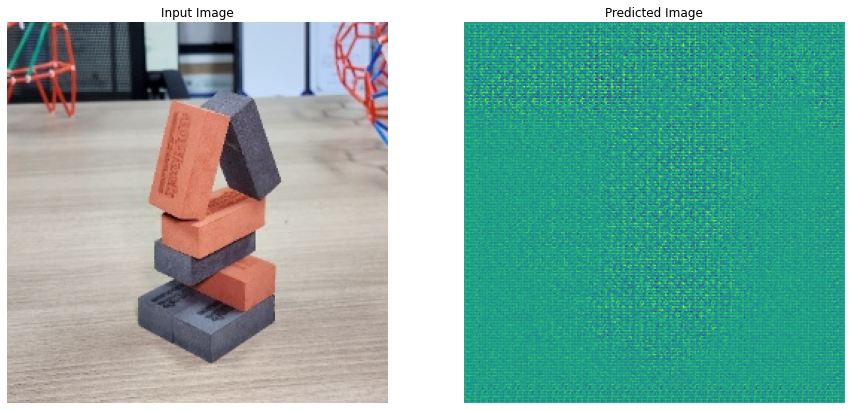

Epoch:  0
.INFO:tensorflow:Error reported to Coordinator: in user code:

    File "/tmp/ipykernel_117591/376410294.py", line 8, in train_step  *
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    File "/tmp/ipykernel_117591/3549227328.py", line 7, in generator_loss  *
        gen_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    File "/home/ubuntu/anaconda3/envs/tt38_cu113/lib/python3.8/site-packages/keras/losses.py", line 154, in __call__  **
        reduction = self._get_reduction()
    File "/home/ubuntu/anaconda3/envs/tt38_cu113/lib/python3.8/site-packages/keras/losses.py", line 205, in _get_reduction
        raise ValueError(

    ValueError: Please use `tf.keras.losses.Reduction.SUM` or `tf.keras.losses.Reduction.NONE` for loss reduction when losses are used with `tf.distribute.Strategy` outside of the built-in training loops. You can implement `tf.keras.losses.Reduction.SUM_OVER_BATCH

ValueError: in user code:

    File "/tmp/ipykernel_117591/500085445.py", line 25, in mirrored_train_step  *
        per_replica_losses = strategy.run(train_step, args=(input_image, target, epoch))
    File "/tmp/ipykernel_117591/376410294.py", line 8, in train_step  *
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    File "/tmp/ipykernel_117591/3549227328.py", line 7, in generator_loss  *
        gen_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    File "/home/ubuntu/anaconda3/envs/tt38_cu113/lib/python3.8/site-packages/keras/losses.py", line 154, in __call__  **
        reduction = self._get_reduction()
    File "/home/ubuntu/anaconda3/envs/tt38_cu113/lib/python3.8/site-packages/keras/losses.py", line 205, in _get_reduction
        raise ValueError(

    ValueError: Please use `tf.keras.losses.Reduction.SUM` or `tf.keras.losses.Reduction.NONE` for loss reduction when losses are used with `tf.distribute.Strategy` outside of the built-in training loops. You can implement `tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE` using global batch size like:
    ```
    with strategy.scope():
        loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    ....
        loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)
    ```
    Please see https://www.tensorflow.org/tutorials/distribute/custom_training for more details.


In [110]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir} --host=0.0.0.0


fit(train_ds, 150)